<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/group_svm/Explore_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore Voxel Distribution 
## Starting with Adolescent
- We will look at the voxel distribution at time point 45 for all plots
- Using different normalization applications:
  - Compare the first 5 subjects for run # 2
  - Compare all runs for the first subject

- Explore Young Adult

## Connect to Gdrive, Clone Repository, Load config files to access data, and import packages and modules

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')#, force_remount = True)

# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/group_svm
!ls


In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
# Import libraries
!pip install boto3 nilearn

from access_data import *
from process import *
from visualize import *
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


## Access and load Unnormalized fMRI data

In [4]:
%%time
#pkl_file = "whole_brain_all_norm_2d.pkl" # normalized by psc
pkl_file = 'all_data_dictionary.pkl' #Unnormalized
bool_mat = False
data = access_load_data(pkl_file, bool_mat)

CPU times: user 26.4 s, sys: 30.7 s, total: 57.1 s
Wall time: 1min 16s


In [5]:
#open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
subject_ids = data_path_dict['subject_ID']

# Split dataset into young children and older children/young adults
AD = subject_ids[:33]
YA = subject_ids[33:]
print(f"Number of subjects for Adolescent {len(AD)} and Young Adults {len(YA)}")

Number of subjects for Adolescent 33 and Young Adults 19


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from nilearn.signal import clean






def plot_dist_across_subjects(data, run, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img):
  """

  :param data     : (dict: keys: 'string', values: nd.array) 52 subject data stored in a dictionary
  :param run      : (int) which run is being represented (out of 4) per subject
  :param num_bins : (int) how many bins to create for histogram
  :param sub_ids  : (string) represents the subject id
  :param norm: (string) how do we want to represent our data. Options: 'PSC_ZNORM', 'Z-Normalized',
                    'Unnormalized', 'Percent Signal Change'
  :param n_sub    : (int) how many subjects do we want to look at
  :return         : Plots n_sub subplots representing n_sub subjects for specified run and type of represented data
                    as defined by norm.
  """
  small_set = []
  hist_sub_ids = sub_ids[:n_sub]

  # Choose time point 45
  for id_ in hist_sub_ids:
    #print(data[id_][run][44:45,:].shape)
    if norm == "Z-score":
      print(f"Running {norm}...")
      x = clean(data[id_][run],
                standardize='zscore',
                detrend=detrend,
                filter=False,
                standardize_confounds=False
                )
      small_set.append(np.array(np.mean(x, axis = 0))) #Average the timepoints #d[44:45,:])
    elif norm == "Percent Signal Change":
      print(f"Running {norm}...")
      x = clean(data[id_][run],
                standardize='psc',
                detrend=detrend,
                filter=False,
                standardize_confounds=False
                )
      small_set.append(np.array(np.mean(x, axis = 0)))
    elif norm == 'Unnormalized':
      print("No Normalization...")
      x = clean(data[id_][run],
                standardize=False,
                detrend=detrend,
                filter=False,
                standardize_confounds=False
                )
      small_set.append(np.array(np.mean(x, axis = 0)))
      
  if plot_img == False:
    return small_set
  else:
    # Create subplots
    fig, axs = plt.subplots(len(small_set[:n_sub]))
    fig.set_figheight(20)
    fig.set_figwidth(10)
    fig.suptitle(f'\n\n\n\n\nDetrended {norm} Voxel Histogram')

    for indx, arr in enumerate(small_set[:n_sub]):
      if norm == "Z-score":
        axs[indx].title.set_text(f"{data_type} Subject {indx + 1} Averaged Across Run {run+1} Timepoints")
        axs[indx].hist(arr, num_bins, facecolor='lightblue', log = True, range = (-.0000001, .0000001)) # removed outliers
      elif norm == "Percent Signal Change":
        axs[indx].title.set_text(f"{data_type} Subject {indx + 1} Averaged Across Run {run+1} Timepoints")
        axs[indx].hist(arr, num_bins, facecolor='lightblue', log = True, range = (-.0000001, .0000001)) # removed outliers
      elif norm == 'Unnormalized':
        axs[indx].title.set_text(f"{data_type} Subject {indx + 1} Averaged Across Run {run+1} Timepoints")
        axs[indx].hist(arr, num_bins, facecolor='lightblue', log = True)#, range = (-.0000001, .0000001))#, range = (-200, 200)) #, width = 1500)

    
    plt.savefig(f'/content/gdrive/MyDrive/sub_norm/five_{data_type}_run{run + 1}_vox_hist_{norm}.png', dpi = 200)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


  
    





def plot_dist_first_subject(data, num_bins, data_norm, detrend, data_type, plot_img):
  """

  :param data     : (dict: keys: 'string', values: nd.array) 52 subject data stored in a dictionary
  :param num_bins : (int) How many bins to create for histogram
  :param data_norm: (string) How do we want to represent our data. Options: 'PSC_ZNORM', 'Z-Normalized',
                      'Unnormalized', 'Percent Signal Change'
  :return         : Plots 4 subplots representing the first subject for all 4 runs and type of represented data
                      as defined by data_norm.
  """

  subject = list(data.keys())[0]
  X_single_4run = data[subject]
  single_4run_norm = []

  if data_norm == "Z-score":
    print(f"Running {data_norm}...")
    for ind_ in range(len(X_single_4run)):
      x = clean(X_single_4run[ind_],
                standardize='zscore',
                detrend=detrend,
                filter=False,
                standardize_confounds=False
                )
      single_4run_norm.append(np.array(np.mean(x, axis = 0)))
  elif data_norm == "Percent Signal Change":
    print(f"Running {data_norm}...")
    for ind_ in range(len(X_single_4run)):
      x = clean(X_single_4run[ind_],
                standardize='psc',
                detrend=detrend,
                filter=False,
                standardize_confounds=False
                )
      single_4run_norm.append(np.array(np.mean(x, axis = 0)))
  elif data_norm == "Unnormalized":
    print("Unnormalized data...")
    for ind_ in range(len(X_single_4run)):
      x = clean(X_single_4run[ind_],
                standardize=False,
                detrend=detrend,
                filter=False,
                standardize_confounds=False
                )
      single_4run_norm.append(np.array(np.mean(x, axis = 0)))


  if plot_img == False:
    return single_4run_norm
  else:
    fig, axs = plt.subplots(len(single_4run_norm))
    fig.set_figheight(20)
    fig.set_figwidth(10)
    fig.suptitle(f'\n\n\n\nDetrended {data_norm} Voxel Histogram for {data_type} subject across {len(single_4run_norm)} runs')
    
    for indx, matrix in enumerate(single_4run_norm):
      if data_norm == "Z-score":
        axs[indx].title.set_text(f"{data_type} Subject Averaged Across Run {indx+1} Timepoints")
        axs[indx].hist(matrix, num_bins, facecolor='lightblue', log = True, range = (-.0000001, .0000001))#, range = (-200, 200)) # removed outliers
      elif data_norm == "Percent Signal Change":
        axs[indx].title.set_text(f"{data_type} Subject Averaged Across Run {indx+1} Timepoints")
        axs[indx].hist(matrix, num_bins, facecolor='lightblue', log = True, range = (-.0000001, .0000001))#, range = (-200, 200)) # removed outliers
      else:
        axs[indx].title.set_text(f"{data_type} Subject Averaged Across Run {indx+1} Timepoints")
        axs[indx].hist(matrix, num_bins, facecolor='lightblue', log = True)#range = (-.0000001, .0000001))

    plt.savefig(f'/content/gdrive/MyDrive/sub_norm/single_sub/{data_type}_vox_hist_{data_norm}.png', dpi = 200)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])







import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def five_sub_ani(data1, title, save_path, n_sub):

  number_of_frames = n_sub
  data2 = np.array(data1)
  num_bins = 1000

  def update_hist(num, data2):
      plt.cla()
      plt.hist(data2[num],1000, facecolor='lightgreen', log = True, range = (-.0000001, .0000001))

  fig, axs = plt.subplots()
  fig.set_figheight(5)
  fig.set_figwidth(8)
  fig.suptitle(title)
  hist = axs.hist(data2[0], 1000, facecolor='lightgreen', log = True, range = (-.0000001, .0000001))

  ani = animation.FuncAnimation(fig, 
                                update_hist, 
                                number_of_frames, 
                                interval=500, 
                                fargs=(data2, )
                                )

  with open(save_path, "w") as f:
    print(ani.to_html5_video(), file=f)

  return ani

## Plot Distribution of first 5 subjects on Not Detrended, Unnormalized data for Adolescent

No Normalization...
No Normalization...
No Normalization...
No Normalization...
No Normalization...


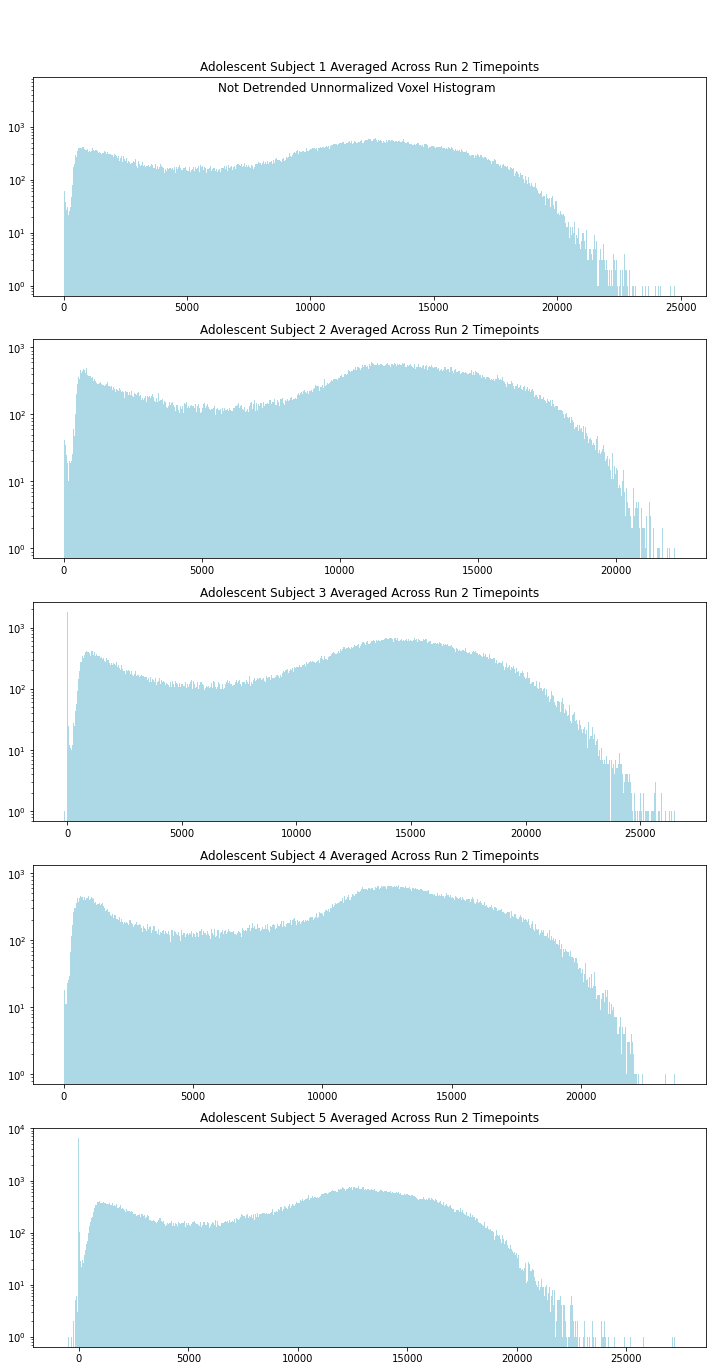

In [142]:
n_sub = 5
runs = 1
num_bins = 1000
plot_img = True
sub_ids = AD
detrend = False
norm = "Unnormalized" # Z-score, Percent Signal Change
data_type = "Adolescent"


plot_dist_across_subjects(data, runs, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img)


We can see that our data is not fitting a normal distribution so let's see how detrending the time series looks along with unnormalized and normalized data. 

## Let us Detrend the Time series and replot the Unnormalized Data for Adolescents


No Normalization on detrended data...
No Normalization on detrended data...
No Normalization on detrended data...
No Normalization on detrended data...
No Normalization on detrended data...


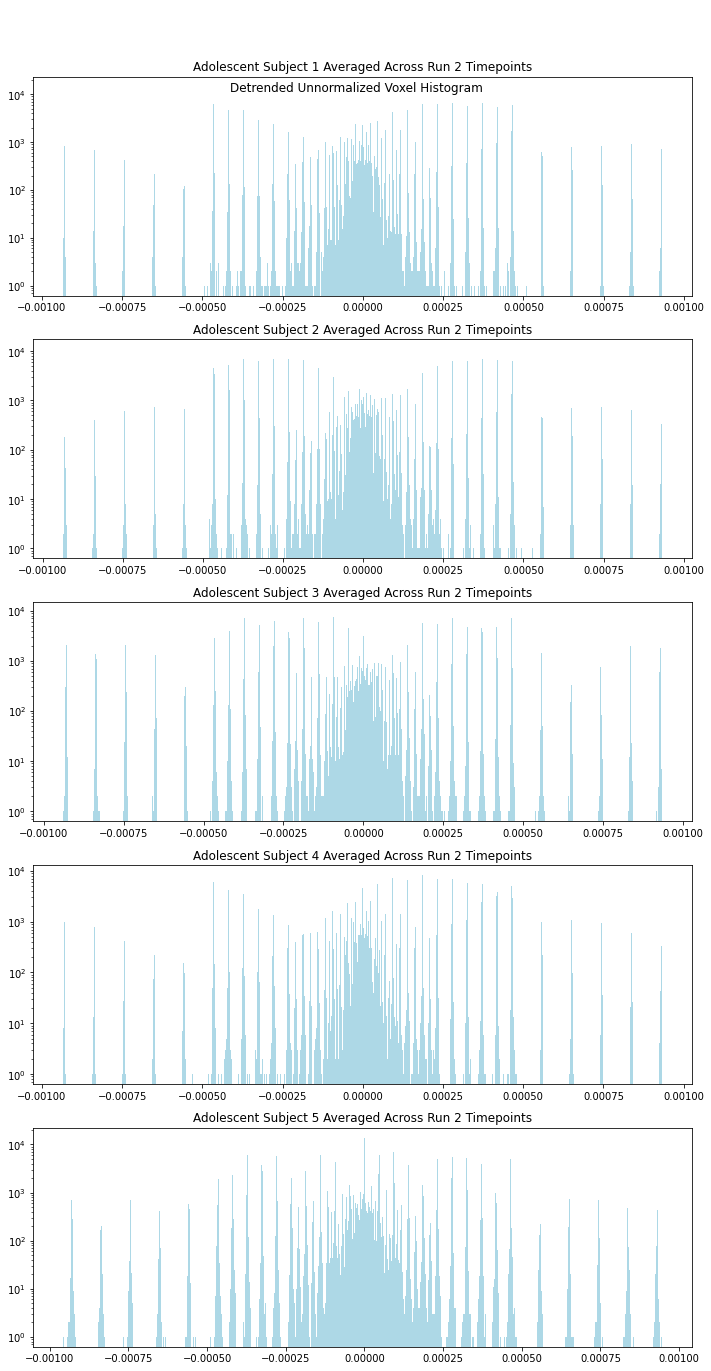

In [139]:
n_sub = 5
runs = 1
num_bins = 1000
sub_ids = AD
plot_img = True
detrend = True
norm = "Unnormalized" # Z-score, Percent Signal Change
data_type = "Adolescent"


plot_dist_across_subjects(data, runs, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img)

Detrending takes the data and works it into a normal distribution. However, there is a lot of spread with the data. Let's apply Percent Signal Change normalization to see how this improves the voxel distribution.

## Plot Distribution of first 5 subjects on data for Adolescent that has been normalized by Percent Signal Change

Running Percent Signal Change...


/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:83: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:87: UserWarning:

psc standardization strategy is meaningless for features that have a mean of 0. These time series are set to 0.



Running Percent Signal Change...
Running Percent Signal Change...
Running Percent Signal Change...
Running Percent Signal Change...


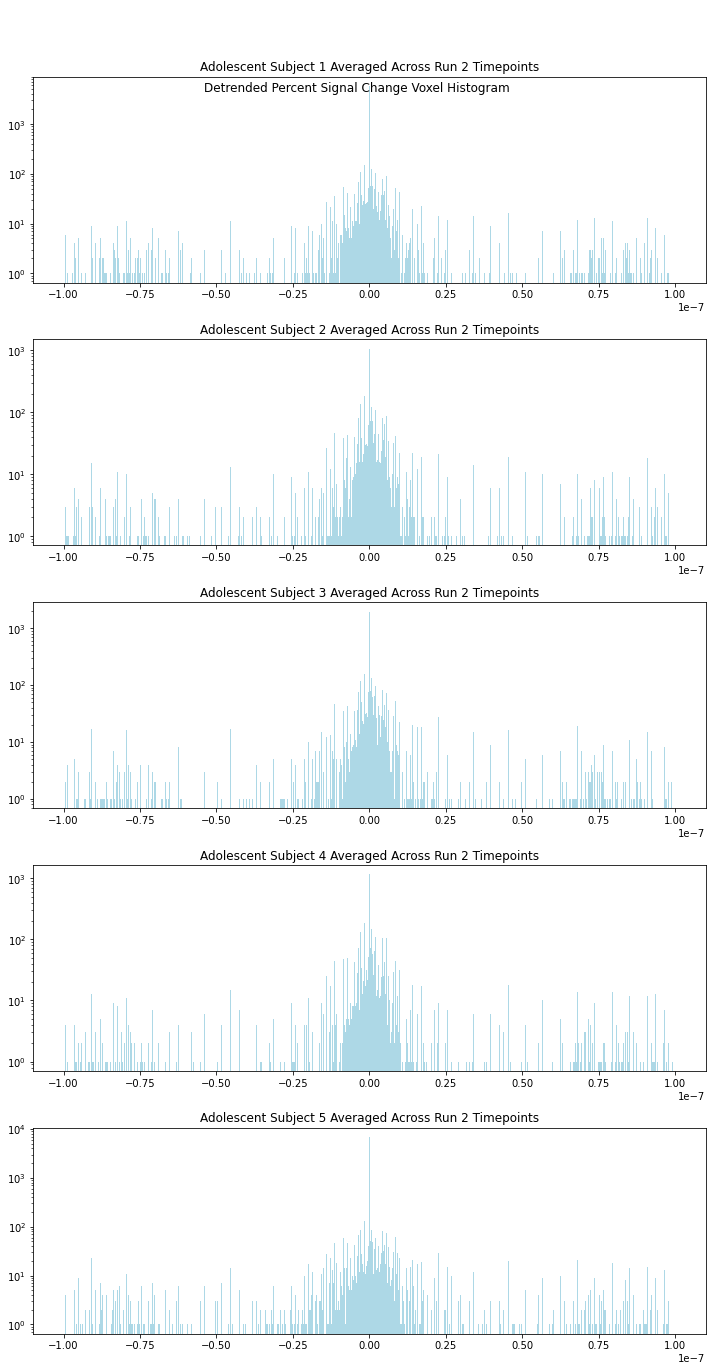

In [145]:
norm = "Percent Signal Change" # Unnormalized, Percent Signal Change, Z-score
n_sub = 5
runs = 1 # on run 2 (index starts at 0)
num_bins = 1000
plot_img = True
sub_ids = AD
detrend = True
data_type = "Adolescent"

plot_dist_across_subjects(data, runs, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img)

The spred is still pretty large and varied. We can try Z-score normalization instead since although Percent Signal Change is widely used in neuroimaging data, its application as a means of normalizing fMRI data is debated in the research community. Z-score is widely used. 

In [ ]:
# Plot the interactive version 
save_path = "/content/gdrive/MyDrive/sub_norm/ADdtrndpscnormvid.html"
plot_img = False
title = f'Adolescent Percent Signal Change Voxel Histogram Averaged over Timepoints for Run 2'
data3 = plot_dist_across_subjects(data, runs, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img)
anim = five_sub_ani(data3, title, save_path, n_sub)
anim

## Plot Distribution of first 5 subjects on data for Adolescent by applying Z-score Normalization

Running Z-score...
Running Z-score...
Running Z-score...
Running Z-score...
Running Z-score...


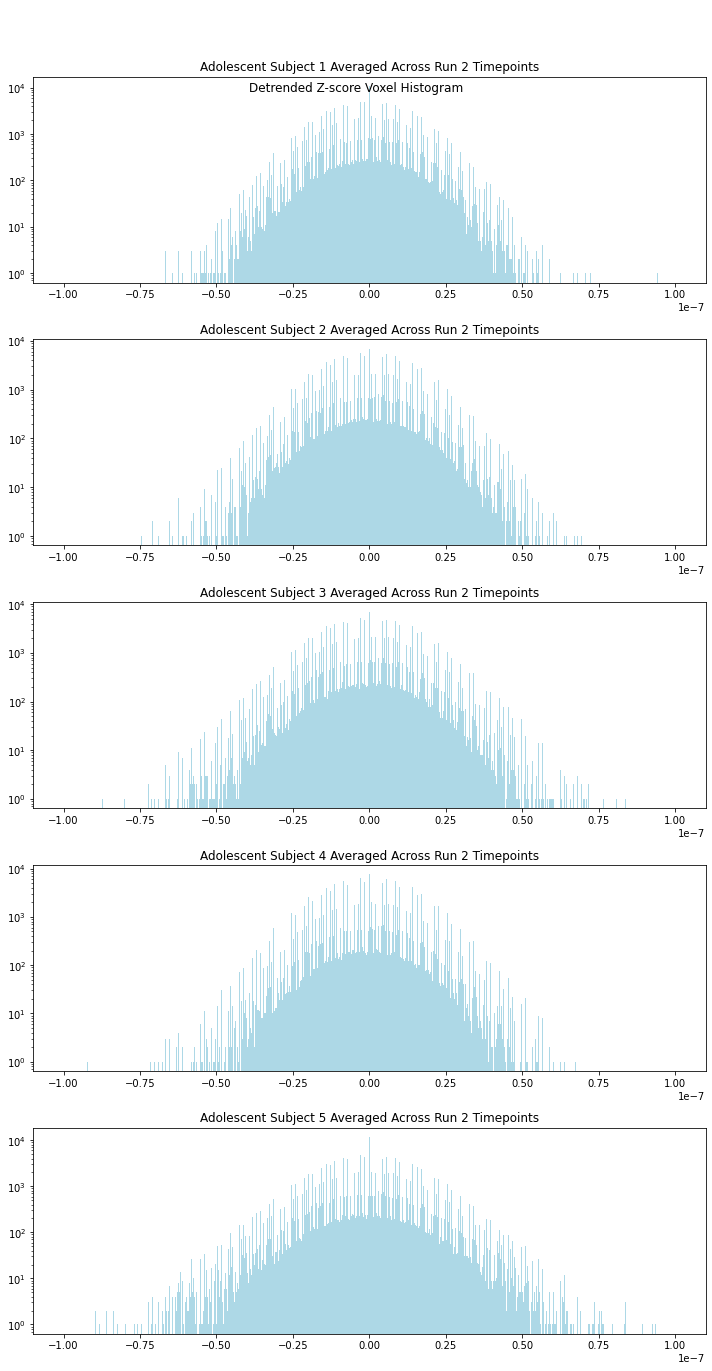

In [11]:
norm = "Z-score" # Unnormalized, Percent Signal Change
n_sub = 5
runs = 1 # on run 2 (index starts at 0)
num_bins = 1000
plot_img = True
sub_ids = AD
detrend = True
data_type = "Adolescent"

plot_dist_across_subjects(data, runs, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img)

In [ ]:
# Plot the interactive version 
save_path = "/content/gdrive/MyDrive/sub_norm/ADdtrnd_ZSCORE_normvid.html"
plot_img = False
title = f'Z-score Norm: Adolescent Voxel Histogram Averaged over Timepoints for Run 2'
data3 = plot_dist_across_subjects(data, runs, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img)
anim = five_sub_ani(data3, title, save_path, n_sub)
anim

It appears that Z-score normalization holds a much tighter/narrow distribution of the data than Unnormalized, Not detrended, and Percent Signal Change. 

We would be curious to see how the voxel distributions compare for subjects between all 4 runs in the MR machine. In the following section we will explore Distribution without Normalization and with normalization between runs for a given subject, as well as with Young Adult subjects.

## Plot distribution of first 4 runs of first subject on Detrended Unnormalized Data for Adolescent 

Unnormalized data...


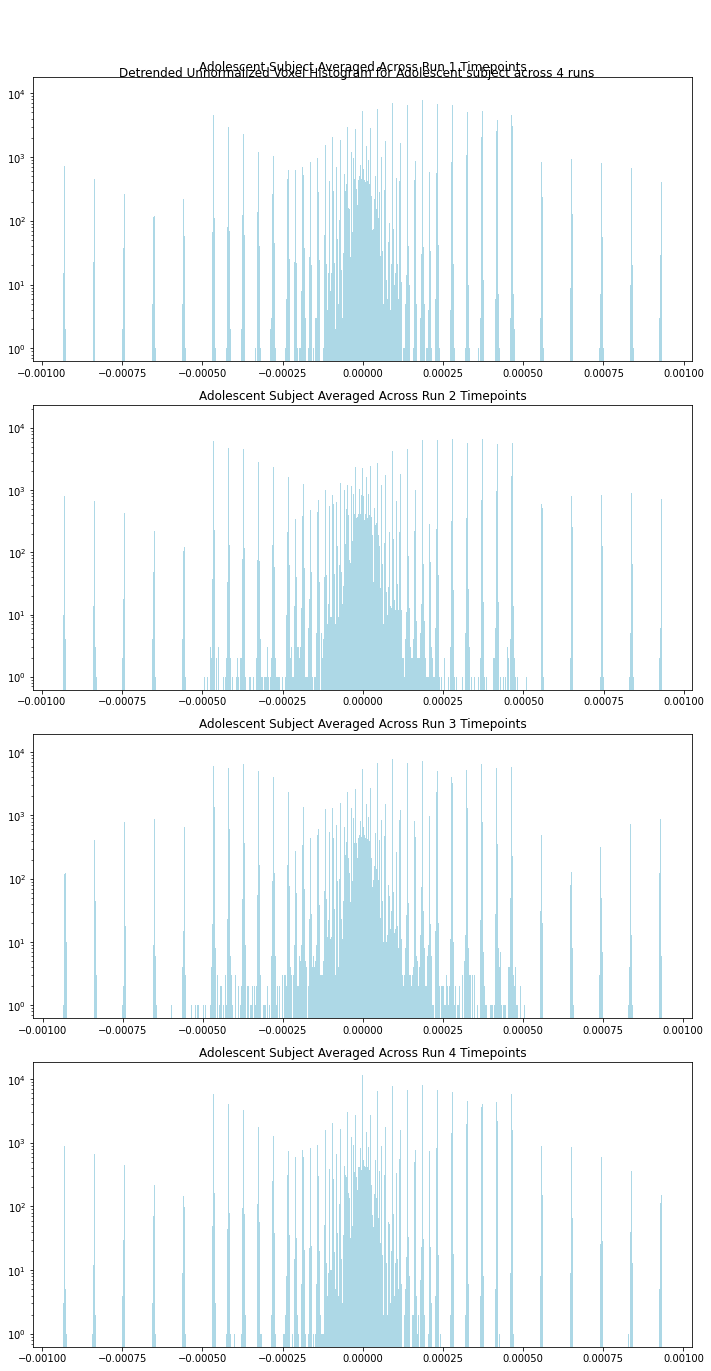

In [33]:
data_norm = "Unnormalized" # Unnormalized, Percent Signal Change
num_bins = 1000
plot_img = True
detrend = True
data_type = "Adolescent"

plot_dist_first_subject(data, num_bins, data_norm, detrend, data_type, plot_img)

## Plot Distribution of first 4 runs of first subject on Adolescent data that has been normalized by Percent Signal Change

Running Percent Signal Change...


/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:83: RuntimeWarning: invalid value encountered in true_divide
  signals = (signals - mean_signal) / np.absolute(mean_signal)
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:87: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '


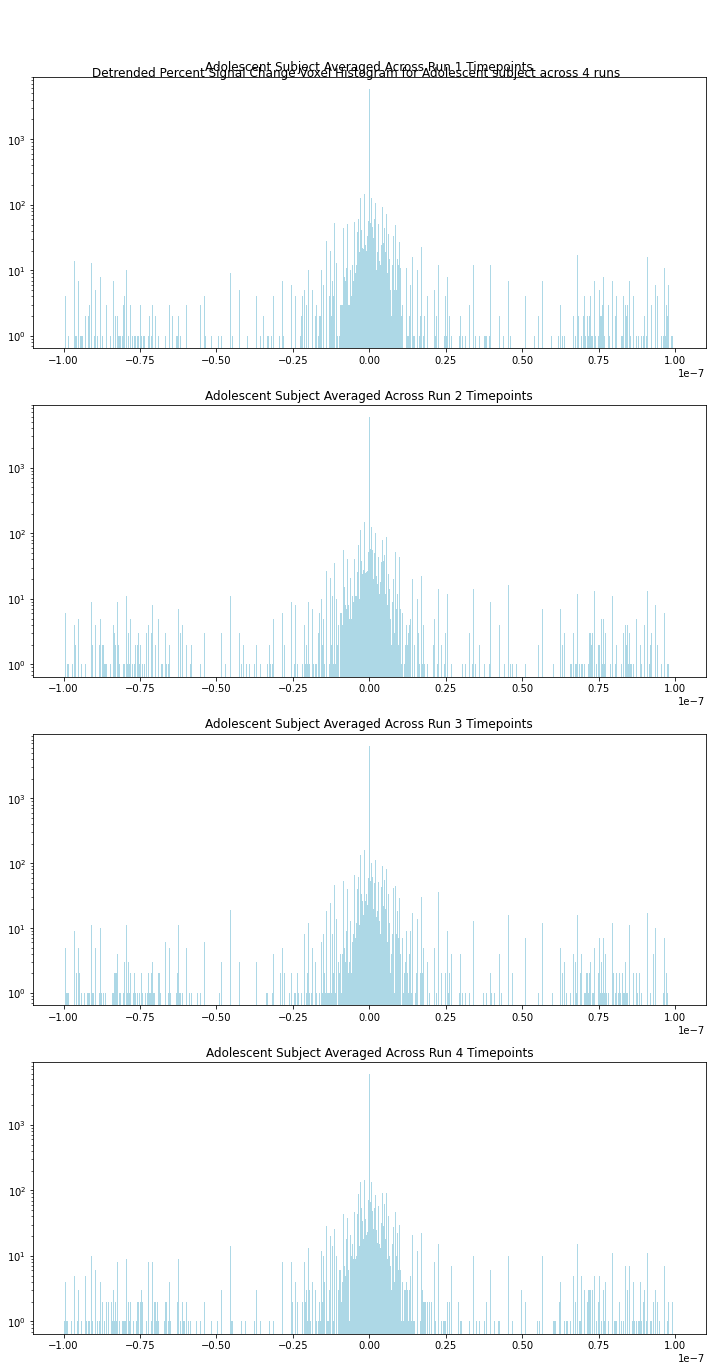

In [35]:
data_norm = "Percent Signal Change" # Unnormalized, Percent Signal Change, #Z-score
num_bins = 1000
plot_img = True
detrend = True
data_type = "Adolescent"

plot_dist_first_subject(data, num_bins, data_norm, detrend, data_type, plot_img)

We can see there is still some noise with applying percent signal change. Let's try applying z-score normalization on top of our percent signal changed data!

## Plot distribution of first 4 runs of first subject on Adolescent by applying Z-score Normalization

Running Z-score...


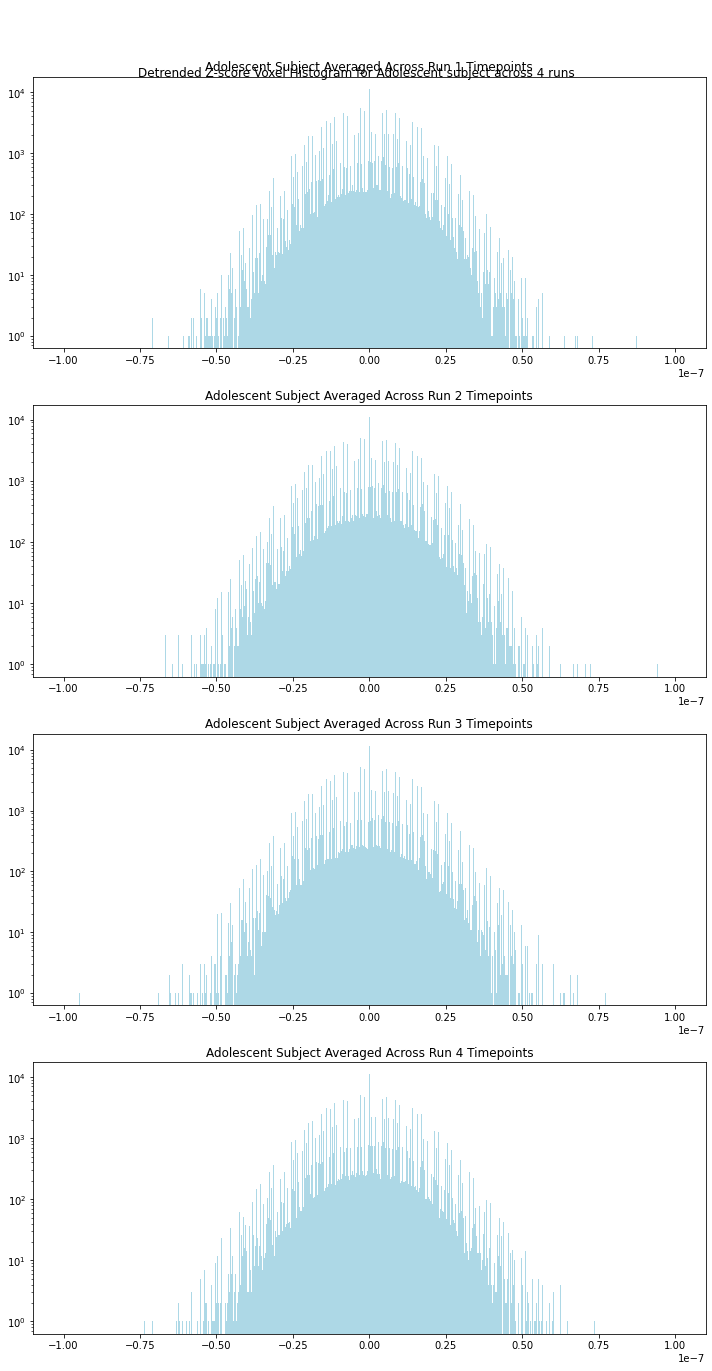

In [34]:
data_norm = "Z-score" # Unnormalized, Percent Signal Change, Z-score
num_bins = 1000
plot_img = True
detrend = True
data_type = "Adolescent"

plot_dist_first_subject(data, num_bins, data_norm, detrend, data_type, plot_img)

# Plot Young Adult across 5 Subjects
- visualize animation of the first 5 subjects' average voxel distributions for run 2 (Feedback Cycle)

### Detrended and Unnormalized

No Normalization...
No Normalization...
No Normalization...
No Normalization...
No Normalization...


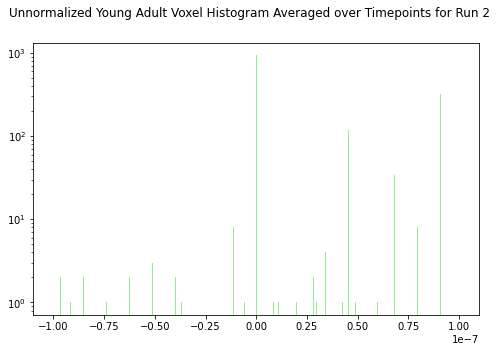

In [43]:
norm = "Unnormalized" # Unnormalized, Percent Signal Change, Z-score
n_sub = 5
runs = 1 # on run 2 (index starts at 0)
num_bins = 1000
plot_img = False # want to get the HTML render
sub_ids = YA
detrend = True
data_type = "Young Adult"

# Plot the interactive version 
save_path = "/content/gdrive/MyDrive/sub_norm/YA_dtrnd_Unorm_mvid.html"
title = f'Unnormalized Young Adult Voxel Histogram Averaged over Timepoints for Run 2'
data3 = plot_dist_across_subjects(data, runs, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img)
anim = five_sub_ani(data3, title, save_path, n_sub)
anim

### Detrended with Percent Signal Change

Running Percent Signal Change...


/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:83: RuntimeWarning: invalid value encountered in true_divide
  signals = (signals - mean_signal) / np.absolute(mean_signal)
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:87: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '


Running Percent Signal Change...
Running Percent Signal Change...
Running Percent Signal Change...
Running Percent Signal Change...


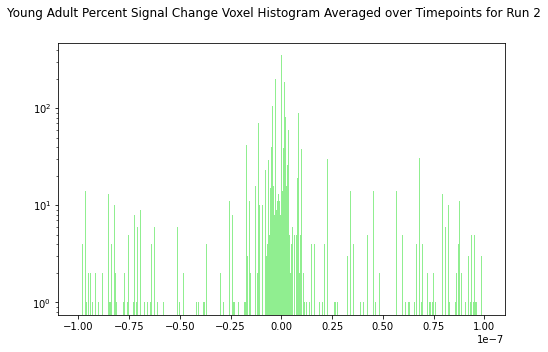

In [44]:
norm = "Percent Signal Change" # Unnormalized, Percent Signal Change, Z-score
n_sub = 5
runs = 1 # on run 2 (index starts at 0)
num_bins = 1000
plot_img = False
sub_ids = YA
detrend = True
data_type = "Young Adult"


# Plot the interactive version 
save_path = "/content/gdrive/MyDrive/sub_norm/YA_dtrnd_psc_normvid.html"
title = f'Young Adult Percent Signal Change Voxel Histogram Averaged over Timepoints for Run 2'
data3 = plot_dist_across_subjects(data, runs, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img)
anim = five_sub_ani(data3, title, save_path, n_sub)
anim

### Detrended with Z-score Normalization

Running Z-score...
Running Z-score...
Running Z-score...
Running Z-score...
Running Z-score...


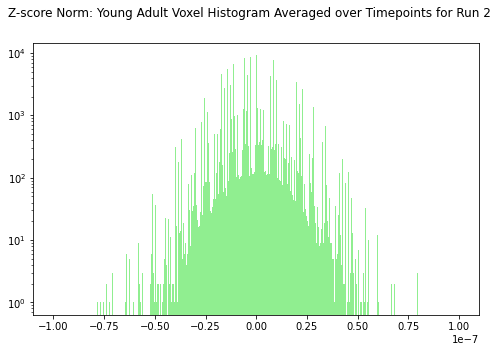

In [45]:
norm = "Z-score" # Unnormalized, Percent Signal Change, Z-score
n_sub = 5
runs = 1 # on run 2 (index starts at 0)
num_bins = 1000
plot_img = False
sub_ids = YA
detrend = True
data_type = "Young Adult"


# Plot the interactive version 
save_path = "/content/gdrive/MyDrive/sub_norm/YA_dtrnd_ZSCORE_normvid.html"
title = f'Z-score Norm: Young Adult Voxel Histogram Averaged over Timepoints for Run 2'
data3 = plot_dist_across_subjects(data, runs, num_bins, sub_ids, norm, n_sub, data_type, detrend, plot_img)
anim = five_sub_ani(data3, title, save_path, n_sub)
anim

## Takaways:
- Z-score normalization appears to work per subject, per run for our data
- Applying Z-score normalization to unnormalized data or data that has been also normalized by percent signal change yields very similar distributions.  
- We can use these distribution graphs to help make decisions on how to normalize our data in preparation for SVM and Deep Learning analyses